In [1]:
!pip3 install gymnasium[classic-control]
!pip3 install pyvirtualdisplay
!pip3 install pyglet
!apt install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math
import gymnasium as gym
from collections import namedtuple, deque
from itertools import count

import imageio
from tqdm import tqdm

import base64
import IPython

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [4]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [5]:
class DiscretizedActionWrapper(gym.ActionWrapper):
    def __init__(self, env, n_actions):
        super(DiscretizedActionWrapper, self).__init__(env)
        self.n_actions = n_actions
        self.action_space = gym.spaces.Discrete(n_actions)
        self.continuous_action_space = env.action_space
        self.actions = np.linspace(self.continuous_action_space.low,
                                   self.continuous_action_space.high,
                                   self.n_actions)

    def action(self, action):
        continuous_action = self.actions[action]
        return continuous_action

In [6]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [7]:
device = torch.device("cuda")

In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque([], maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [9]:
class Policy(nn.Module):
    def __init__(self, obs, act):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(obs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, act)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [10]:
def record_video(env, policy, out, iterations, fps=30):
    images = []
    for _ in range(iterations):
        done = False
        state, info = env.reset()
        img = env.render()
        images.append(img)
        while not done:
            action, _ = policy.act(state)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            img = env.render()
            images.append(img)
    imageio.mimsave(out, [np.array(img) for i, img in enumerate(images)], fps=fps)
    return out

In [11]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [12]:
hyperparameters = {
    "h_size": 128,
    "n_training_episodes": 2000,
    "n_evaluation_episodes": 10,
    "eps_start": 0.9,
    "eps_end": 0.05,
    "eps_decay": 1000,
    "gamma": 0.99,
    "lr": 1e-4,
    "tau": 0.005,
}

In [13]:
act = env.action_space.n
state, info = env.reset()
obs = len(state)

In [14]:
policy_net = Policy(obs, act).to(device)
target_net = Policy(obs, act).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [15]:
optimizer = optim.AdamW(policy_net.parameters(), lr=hyperparameters["lr"], amsgrad=True)
replay_buffer = ReplayBuffer(10000)

In [16]:
num_steps = 0
episode_durations = []

In [17]:
def eps_greedy(state):
    global num_steps
    decay_term = math.exp(-1. * num_steps / hyperparameters["eps_decay"])
    eps = hyperparameters["eps_end"] + (hyperparameters["eps_start"] - hyperparameters["eps_end"]) * decay_term
    num_steps += 1
    if random.random() <= eps:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)

In [18]:
def train_loop():
    if len(replay_buffer) < hyperparameters["h_size"]:
        return
    transitions = replay_buffer.sample(hyperparameters["h_size"])
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(hyperparameters["h_size"], device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * hyperparameters["gamma"]) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [19]:
for _ in tqdm(range(hyperparameters["n_training_episodes"]), desc="Training"):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = eps_greedy(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        replay_buffer.push(state, action, next_state, reward)
        state = next_state
        train_loop()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * hyperparameters["tau"] + target_net_state_dict[key] * (1 - hyperparameters["tau"])
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

Training: 100%|██████████| 2000/2000 [37:37<00:00,  1.13s/it]


Text(0, 0.5, 'Duration')

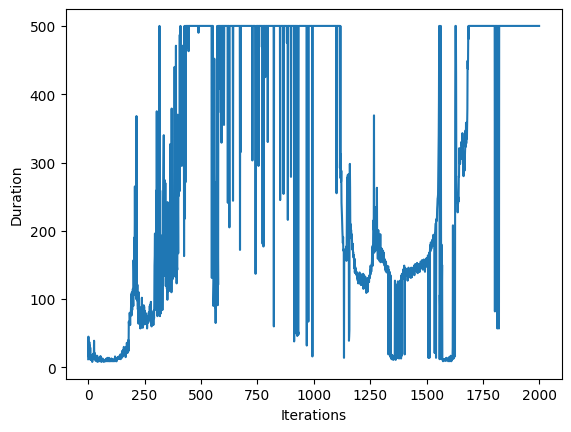

In [20]:
durations_t = torch.tensor(episode_durations, dtype=torch.float)
plt.plot(durations_t.numpy())
plt.xlabel('Iterations')
plt.ylabel('Duration')

In [21]:
torch.save(policy_net, "dqn_model.pt")
record_video(env, policy_net, "cartpole.mp4", 30, 30)
embed_mp4("cartpole.mp4")